In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

from sklearn.preprocessing import StandardScaler

import os

from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('data/train/train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [5]:
train['GHI'] = train['DHI']+train['DNI']

In [6]:
train.insert(3,'Time',train['Hour']+ (train['Minute'] == 30) *0.5 )

### Time (Hour,Minute)

In [8]:
del train['Minute']

In [10]:
del train['Hour']

### DAY preprocessing

In [28]:
train.insert(0,'Day_' , (train['Day']%365)+1 )

In [31]:
train = train.drop(['Day'],axis=1)

- 365days -> month

In [33]:
import calendar 

In [40]:
days_per_month =list( map(lambda x : calendar.monthrange(2018,x)[1],range(1,13) 
                         ))

In [59]:
dpm = days_per_month
dpm

[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [60]:
def get_month(days):
    sum = 0
    for i,x in enumerate(dpm) :
        sum += x
        if days <= sum :
            month = i + 1
            break
    return month
        

In [76]:
train['Month'] = train['Day_'].map(get_month)

In [78]:
train = train[['Month','Time','GHI','DHI','DNI','WS',	'RH'	,'T'	,'TARGET'	]]

- categorize month to another set

#### k-means 를 이용하여 12월개을 적절하게 카테고리화 
#### [k는 알아서 찾도록 함](https://blog.nerdfactory.ai/2018/12/24/minimax-method-to-find-the-number-of-center-of-clustering.html) 

#### pass 

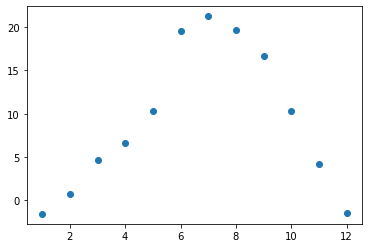

In [85]:
plt.scatter(range(1,13),train.groupby(['Month'])['T'].mean() )

(array([2., 1., 1., 1., 1., 1., 2., 1., 1., 1.]),
 array([ 9.03341286, 10.89786085, 12.76230884, 14.62675683, 16.49120481,
        18.3556528 , 20.22010079, 22.08454877, 23.94899676, 25.81344475,
        27.67789273]),
 <BarContainer object of 10 artists>)

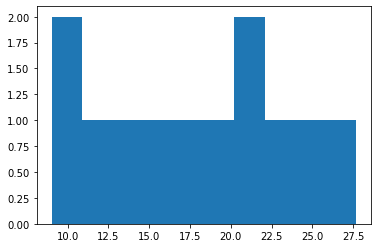

In [84]:
plt.hist(train.groupby(['Month'])['TARGET'].mean() )

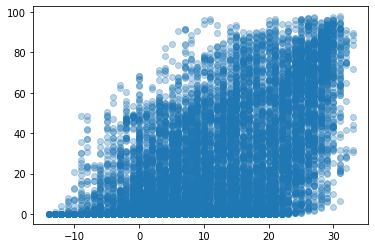

In [90]:
plt.scatter(train[:48*365]['T'],train[:48*365]['TARGET'],alpha=0.3)

### missing value checking

In [96]:
np.sum(train.isna()) #nothing.... it's a mercy ✔

Month     0
Time      0
GHI       0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

### > outlier

##### pass

### > Scaling 

In [101]:
train.columns

Index(['Month', 'Time', 'GHI', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET'], dtype='object')

In [102]:
from sklearn.preprocessing import StandardScaler

In [110]:
standardScaler = StandardScaler()
train_scaled = train[['Time','DNI','DHI','GHI','WS','RH','T','TARGET']]
print(standardScaler.fit(train_scaled))
train_scaled = standardScaler.transform(train_scaled)
train_scaled = pd.DataFrame(train_scaled)

StandardScaler()


In [111]:
train_scaled.columns = ['Time','DNI','DHI','GHI','WS','RH','T','TARGET']

In [115]:
train_scaled.insert(0,'Month',train['Month'])

In [116]:
train_scaled

,Month,Time,DNI,DHI,GHI,WS,RH,T,TARGET
0,1,-1.696335,-0.671447,-0.619312,-0.762223,-0.670026,0.557162,-2.090439,-0.690638
1,1,-1.624150,-0.671447,-0.619312,-0.762223,-0.670026,0.556255,-2.090439,-0.690638
2,1,-1.551966,-0.671447,-0.619312,-0.762223,-0.599942,0.679596,-2.090439,-0.690638
3,1,-1.479781,-0.671447,-0.619312,-0.762223,-0.599942,0.678235,-2.090439,-0.690638
4,1,-1.407597,-0.671447,-0.619312,-0.762223,-0.599942,0.834679,-2.090439,-0.690638
...,...,...,...,...,...,...,...,...,...
52555,12,1.407597,-0.671447,-0.619312,-0.762223,-0.039270,0.630622,-1.304557,-0.690638
52556,12,1.479781,-0.671447,-0.619312,-0.762223,-0.039270,0.453319,-1.304557,-0.690638
52557,12,1.551966,-0.671447,-0.619312,-0.762223,-0.179438,0.452866,-1.304557,-0.690638
52558,12,1.624150,-0.671447,-0.619312,-0.762223,-0.249522,0.495491,-1.304557,-0.690638


### LSTM model

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\epsilon\dev\Anaconda\lib\http\client.py", line 458, in read
    n = self.readinto(b)
  File "C:\Users\epsilon\dev\Anaconda\lib\http\client.py", line 502, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\epsilon\dev\Anaconda\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\epsilon\dev\Anaconda\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\epsilon\dev\Anaconda\lib\ssl.py", line 1099, in read
    r


  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\cli\req_command.py", line 182, in wrapper
    return func(self, options, args)
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\commands\install.py", line 323, in run
    requirement_set = resolver.resolve(
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\resolution\legacy\resolver.py", line 183, in resolve
    discovered_reqs.extend(self._resolve_one(requirement_set, req))
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\resolution\legacy\resolver.py", line 388, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\resolution\legacy\resolver.py", line 340, in _get_abstract_dist_for
    abstract_dist = self.preparer.prepare_linked_requirement(req)
  File "C:\Users\epsilon\dev\Anaconda\lib\site-packages\pip\_internal\operations\prepare.py", line 467, in prepare

In [119]:
!python -V

Python 3.8.5


In [117]:
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# from tensorflow.keras.utils import to_categorical
# one_hot = to_categorical(encoded)

In [109]:
train_scaled

,Month,Time,DNI,DHI,GHI,WS,RH,T,TARGET
0,-1.602745,-1.696335,-0.671447,-0.619312,-0.762223,-0.670026,0.557162,-2.090439,-0.690638
1,-1.602745,-1.624150,-0.671447,-0.619312,-0.762223,-0.670026,0.556255,-2.090439,-0.690638
2,-1.602745,-1.551966,-0.671447,-0.619312,-0.762223,-0.599942,0.679596,-2.090439,-0.690638
3,-1.602745,-1.479781,-0.671447,-0.619312,-0.762223,-0.599942,0.678235,-2.090439,-0.690638
4,-1.602745,-1.407597,-0.671447,-0.619312,-0.762223,-0.599942,0.834679,-2.090439,-0.690638
...,...,...,...,...,...,...,...,...,...
52555,1.587648,1.407597,-0.671447,-0.619312,-0.762223,-0.039270,0.630622,-1.304557,-0.690638
52556,1.587648,1.479781,-0.671447,-0.619312,-0.762223,-0.039270,0.453319,-1.304557,-0.690638
52557,1.587648,1.551966,-0.671447,-0.619312,-0.762223,-0.179438,0.452866,-1.304557,-0.690638
52558,1.587648,1.624150,-0.671447,-0.619312,-0.762223,-0.249522,0.495491,-1.304557,-0.690638
